In [15]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
import re, warnings
import scattertext as ST
from pandas.core.common import SettingWithCopyWarning
import spacy
import mpld3
import matplotlib.pyplot as plt
mpld3.enable_notebook()
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
nlp = spacy.en.English()

## Load newsgroup dataset

In [4]:
categories = ['alt.atheism', 'talk.religion.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)

In [5]:
# function to strip out headers from newsgroup posts, remove last full line
def clean_newsgroup_data_factory():
    badline_re = re.compile(r'(^(>|From:|Subject:|Organization:'+
                            '|Distribution:|NNTP-Posting-Host:|Lines:|News-Software:'
                            +'|In article <.+?@.+>)|(writes:?|.com|.edu|.org)$)')
    email_address_finder = re.compile(r'\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b', flags=re.IGNORECASE)
    def clean_newsgroup_data(text):
        return '\n'.join([email_address_finder.sub('', line)
                          for line in text.split('\n') 
                          if badline_re.match(line.strip()) is None][:-1])
    return clean_newsgroup_data

In [6]:
term_doc_matrix_factory = ST.TermDocMatrixFactory(
        category_text_iter = ((categories[idx], text) 
                              for idx, text 
                              in zip(newsgroups.target, newsgroups.data)), # only pass in full category names
        clean_function = clean_newsgroup_data_factory(),
        nlp = nlp)
term_doc_matrix = term_doc_matrix_factory.build()


# See what stands out in the data set against English as a whole

In [16]:
(term_doc_matrix
 .get_scaled_f_score_scores_vs_background()
 .iloc[:10])
# we can also use get_rudder_scores_vs_background, 
# get_posterior_mean_ratio_scores_vs_background, 
# or get_fisher_scores_vs_background

corpus  background  Scaled f-score
koresh          86       73785        0.000647
ksand           42           0        0.000437
atheists       168      795807        0.000340
mozumder        32           0        0.000333
decenso         32           0        0.000333
alink           42       60976        0.000332
livesey         42       78135        0.000311
beauchaine      27           0        0.000281
atheism        153     1022796        0.000252
halat           24           0        0.000250

## See what distinguishes alt.atheism against talk.religion.misc, in terms of Scaled F-Score

In [17]:
df = term_doc_matrix.get_term_freq_df()
df['Scaled f-score'] = term_doc_matrix.get_scaled_f_scores('alt.atheism', scaler_algo = 'percentile')

In [18]:
# other options include get_logistic_regression_coefs_l1, get_rudder_scores, 
#  get_posterior_mean_ratio_scores, and get_fisher_scores
df.sort_values('Scaled f-score', ascending = False).iloc[:10]

alt.atheism freq  talk.religion.misc freq  Scaled f-score
term                                                                 
fallacy                   59                        0        0.803390
keith                     81                        2        0.795159
atheists                 163                        5        0.794615
atheist                  100                        3        0.793864
atheism                  148                        5        0.791177
bobby                     45                        0        0.778628
atheism is                36                        0        0.754163
g'd                       36                        0        0.754163
jon                       73                        5        0.743128
mozumder                  32                        0        0.740652

## In terms of distinguishing l2-penalized logistic regression coefs

In [10]:
df['L2 coefs'], acc, baseline = term_doc_matrix.get_logistic_regression_coefs_l2('alt.atheism')
print 'classifier accuracy', acc
print 'majority-class baseline accuracy', baseline
df.sort_values('L2 coefs', ascending=False).iloc[:10]

classifier accuracy 0.833138856476
majority-class baseline accuracy 0.560093348891


alt.atheism freq  talk.religion.misc freq  Scaled f-score  L2 coefs
term                                                                         
keith                   81                        2        0.795159  1.660576
tammy                   19                        0        0.683664  1.163218
atheism                148                        5        0.791177  1.109764
gregg                   30                        0        0.733227  1.097077
jon                     73                        5        0.743128  1.040266
benedikt                37                        1        0.733063  1.015037
it                    1551                     1041        0.200522  0.991597
islam                  109                       19        0.626260  0.967019
could                  167                       95        0.256823  0.866237
atheist                100                        3        0.793864  0.861706

## The rudder visualization, with posterior ratios as scores.  Write interactive chart and term rankings to alt.atheism.html.

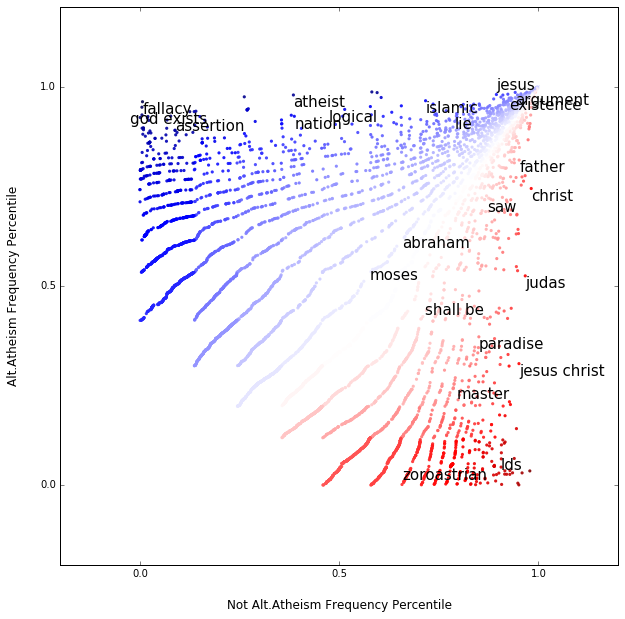

In [19]:
import scattertext as ST
imp.reload(ST)
import scattertext
plt.rcParams['figure.figsize'] = (10, 10)
scatter_chart = ST.ScatterChart(term_doc_matrix,
                                jitter = 0, # 0.05 adds a bit of jitter
                               )
chart_df, chart_html = scatter_chart.draw('alt.atheism',
                      num_top_words_to_annotate = 0,
                      transform = ST.Scalers.percentile_ordinal,
                      scores = term_doc_matrix.get_posterior_mean_ratio_scores('alt.atheism'),
                      words_to_annotate=['lds', 'fallacy', 'assertion', 'god exists', 'logical', 'lie', 'existence', 
                                         'atheist', 'saw', 'shall be', 'paradise', 'argument', 'islamic', 'nation', 
                                         'master', 'jesus', 'abraham', 'moses', 'christ', 'jesus christ',
                                        'judas', 'father', '', 'zoroastrian'])
visualization_fn = open('alt.atheism.html', 'w')
visualization_fn.write(chart_html)
print >>visualization_fn, '<h2>Top terms</h2>'
chart_df.sort_values(by='color_scores', ascending=False)[:30].to_html(visualization_fn)
print >>visualization_fn, '<h2>Bottom terms</h2>'
chart_df.sort_values(by='color_scores', ascending=False)[-30:].to_html(visualization_fn)
visualization_fn.close()